In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/Fish Classifications/Fish_Dataset_updated'  # <- change if needed
OUT_DIR = '/content/drive/MyDrive/moco_fish_outputs_fixed'
!mkdir -p "$OUT_DIR"

import os
assert all(os.path.isdir(os.path.join(DATASET_DIR, d)) for d in ['train','val','test'])
print("Dataset:", DATASET_DIR)
print("Outputs:", OUT_DIR)


Mounted at /content/drive
Dataset: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/Fish_Dataset_updated
Outputs: /content/drive/MyDrive/moco_fish_outputs_fixed


In [3]:
import os, math, time, copy, random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

# Colab-safe multiprocessing
import torch.multiprocessing as mp
try: mp.set_start_method("spawn", force=True)
except RuntimeError: pass

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

CFG = {
    "img_size": 224,
    "batch_size": 128,
    "num_workers": 0,        # 0 = most stable in Colab
    "pin_memory": False,

    "pretrain_epochs": 20,   # you can bump to 50 if you like
    "linear_epochs": 10,     # 30 + 10 = 40; we’ll add fine-tune 10 → total 50
    "finetune_epochs": 10,

    "proj_dim": 128,
    "moco_K": 65536,
    "moco_m": 0.999,
    "moco_T": 0.2,

    "base_lr": 0.03,         # per-256 batch; we scale
    "weight_decay": 1e-4,
    "warmup_epochs": 5,

    "init_imagenet": True,   # <- IMPORTANT: start from ImageNet weights
}


Device: cuda


In [4]:
class TwoCropsTransform:
    def __init__(self, tfm): self.tfm = tfm
    def __call__(self, x):   return self.tfm(x), self.tfm(x)

normalize = transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

moco_train_tf = TwoCropsTransform(transforms.Compose([
    transforms.RandomResizedCrop(CFG["img_size"], scale=(0.2,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(23, sigma=(0.1,2.0)),
    transforms.ToTensor(), normalize,
]))

sup_train_tf = transforms.Compose([
    transforms.RandomResizedCrop(CFG["img_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), normalize,
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(CFG["img_size"]),
    transforms.ToTensor(), normalize,
])

train_unlabeled = datasets.ImageFolder(os.path.join(DATASET_DIR,'train'), transform=moco_train_tf)
train_sup       = datasets.ImageFolder(os.path.join(DATASET_DIR,'train'), transform=sup_train_tf)
val_sup         = datasets.ImageFolder(os.path.join(DATASET_DIR,'val'),   transform=eval_tf)
test_sup        = datasets.ImageFolder(os.path.join(DATASET_DIR,'test'),  transform=eval_tf)

num_classes = len(train_sup.classes)
print("Classes:", num_classes, train_sup.classes[:5], "...")

pretrain_loader = DataLoader(train_unlabeled, batch_size=CFG["batch_size"], shuffle=True,
                             num_workers=CFG["num_workers"], pin_memory=CFG["pin_memory"], drop_last=True)
train_loader    = DataLoader(train_sup, batch_size=CFG["batch_size"], shuffle=True,
                             num_workers=CFG["num_workers"], pin_memory=CFG["pin_memory"])
val_loader      = DataLoader(val_sup, batch_size=CFG["batch_size"], shuffle=False,
                             num_workers=CFG["num_workers"], pin_memory=CFG["pin_memory"])
test_loader     = DataLoader(test_sup, batch_size=CFG["batch_size"], shuffle=False,
                             num_workers=CFG["num_workers"], pin_memory=CFG["pin_memory"])


Classes: 20 ['Aair', 'Boal', 'Chapila', 'DeshiPuti', 'Foli'] ...


In [5]:
def build_backbone():
    if CFG["init_imagenet"]:
        m = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    else:
        m = resnet50(weights=None)
    m.fc = nn.Identity()     # 2048-D features
    return m

class MLPHead(nn.Module):  # MoCo v2 head
    def __init__(self, in_dim=2048, dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 2048, bias=False),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, dim, bias=True)
        )
    def forward(self, x): return self.net(x)

class MoCo(nn.Module):
    def __init__(self, dim=128, K=65536, m=0.999, T=0.2):
        super().__init__()
        self.K, self.m, self.T = K, m, T
        self.encoder_q = build_backbone()
        self.encoder_k = build_backbone()
        self.projector_q = MLPHead(2048, dim)
        self.projector_k = MLPHead(2048, dim)

        # init key encoder = query encoder, then freeze grads on key
        for pq, pk in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            pk.data.copy_(pq.data); pk.requires_grad=False
        for pq, pk in zip(self.projector_q.parameters(), self.projector_k.parameters()):
            pk.data.copy_(pq.data); pk.requires_grad=False

        self.register_buffer("queue", F.normalize(torch.randn(dim, K), dim=0))
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for pq, pk in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            pk.data = pk.data * self.m + pq.data * (1. - self.m)
        for pq, pk in zip(self.projector_q.parameters(), self.projector_k.parameters()):
            pk.data = pk.data * self.m + pq.data * (1. - self.m)

    @torch.no_grad()
    def _enqueue_dequeue(self, keys):
        b = keys.shape[0]; K = self.K
        ptr = int(self.queue_ptr)
        assert K % b == 0, "K must be divisible by batch size"
        self.queue[:, ptr:ptr+b] = keys.T
        ptr = (ptr + b) % K
        self.queue_ptr[0] = ptr

    def encode(self, x):    # 2048-D pooled features (no projector)
        return self.encoder_q(x)

    def forward(self, x1, x2):
        q = self.projector_q(self.encoder_q(x1))
        q = F.normalize(q, dim=1)

        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.projector_k(self.encoder_k(x2))
            k = F.normalize(k, dim=1)

        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.size(0), dtype=torch.long, device=logits.device)

        self._enqueue_dequeue(k)
        return logits, labels


In [6]:
def lr_warmup_cosine(base_lr, epoch, it, iters_per_epoch, total_epochs, warmup_epochs):
    t = epoch + it/iters_per_epoch
    if t < warmup_epochs:
        return base_lr * (t / max(1e-8, warmup_epochs))
    # cosine from base_lr -> 0
    t_adj = (t - warmup_epochs) / max(1e-8, (total_epochs - warmup_epochs))
    return 0.5 * base_lr * (1 + math.cos(math.pi * t_adj))

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


In [7]:
def pretrain_moco(model, loader, epochs):
    model = model.to(device)
    model.train()

    scaled_lr = CFG["base_lr"] * (CFG["batch_size"]/256.0)
    params = list(model.encoder_q.parameters()) + list(model.projector_q.parameters())
    optimizer = torch.optim.SGD(params, lr=scaled_lr, momentum=0.9, weight_decay=CFG["weight_decay"])

    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
    iters = len(loader)
    losses = []

    for ep in range(1, epochs+1):
        ep_loss = 0.0
        pbar = tqdm(loader, desc=f"[MoCo] Epoch {ep}/{epochs}", leave=False)
        for it, ((im_q, im_k), _) in enumerate(pbar):
            im_q = im_q.to(device, non_blocking=True)
            im_k = im_k.to(device, non_blocking=True)

            lr = lr_warmup_cosine(scaled_lr, ep-1, it, iters, epochs, CFG["warmup_epochs"])
            for pg in optimizer.param_groups: pg["lr"] = lr

            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits, labels = model(im_q, im_k)
                loss = F.cross_entropy(logits, labels)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ep_loss += loss.item() * im_q.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{lr:.5f}")

        ep_loss /= (len(loader.dataset) - (len(loader.dataset) % CFG["batch_size"]))
        losses.append(ep_loss)
        print(f"[MoCo] Epoch {ep:02d} | loss {ep_loss:.4f}")

    torch.save({
        "encoder_q": model.encoder_q.state_dict(),
        "projector_q": model.projector_q.state_dict(),
        "cfg": CFG
    }, os.path.join(OUT_DIR, "moco_r50_imnet.pt"))
    print("Saved MoCo to:", os.path.join(OUT_DIR, "moco_r50_imnet.pt"))
    return losses


In [8]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim=2048, num_classes=1000):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.fc(x)

def eval_epoch(backbone, clf, loader, criterion):
    backbone.eval(); clf.eval()
    tl, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device); targets = targets.to(device)
            feats = backbone(imgs)
            logits = clf(feats)
            loss = criterion(logits, targets)
            tl += loss.item() * imgs.size(0)
            correct += (logits.argmax(1) == targets).sum().item()
            total += targets.size(0)
    return tl/max(total,1), correct/max(total,1)

def train_linear_eval(moco_model, train_loader, val_loader, epochs, num_classes):
    backbone = copy.deepcopy(moco_model.encoder_q).to(device)
    for p in backbone.parameters(): p.requires_grad = False

    clf = LinearClassifier(2048, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)

    hist = defaultdict(list)
    best, best_path = 0.0, os.path.join(OUT_DIR, "linear_best.pt")

    for ep in range(1, epochs+1):
        backbone.eval(); clf.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[Linear] Epoch {ep}/{epochs}", leave=False)
        for imgs, targets in pbar:
            imgs = imgs.to(device); targets = targets.to(device)
            with torch.no_grad():
                feats = backbone(imgs)
            logits = clf(feats)
            loss = criterion(logits, targets)
            optimizer.zero_grad(set_to_none=True)
            loss.backward(); optimizer.step()

            tr_loss += loss.item() * imgs.size(0)
            tr_correct += (logits.argmax(1) == targets).sum().item()
            tr_total += targets.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = tr_loss/max(tr_total,1)
        train_acc  = tr_correct/max(tr_total,1)
        val_loss, val_acc = eval_epoch(backbone, clf, val_loader, criterion)

        hist["train_loss"].append(train_loss); hist["train_acc"].append(train_acc)
        hist["val_loss"].append(val_loss);     hist["val_acc"].append(val_acc)

        print(f"[Linear] Ep {ep:02d} | tr {train_loss:.4f}/{train_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f}")

        if val_acc > best:
            best = val_acc
            torch.save({"backbone": backbone.state_dict(),
                        "classifier": clf.state_dict(),
                        "classes": num_classes,
                        "cfg": CFG}, best_path)

    print("Best val acc:", round(best,4), "path:", best_path)
    return backbone, clf, hist


In [9]:
def finetune_full(backbone, clf, train_loader, val_loader, epochs):
    for p in backbone.parameters(): p.requires_grad = True
    model = nn.Sequential(backbone, clf).to(device)

    # smaller LR for backbone, larger for head
    optimizer = torch.optim.AdamW([
        {"params": backbone.parameters(), "lr": 1e-4},
        {"params": clf.parameters(),      "lr": 3e-4},
    ], weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    hist = defaultdict(list)
    best, best_path = 0.0, os.path.join(OUT_DIR, "finetune_best.pt")

    for ep in range(1, epochs+1):
        model.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[Finetune] Epoch {ep}/{epochs}", leave=False)
        for imgs, targets in pbar:
            imgs = imgs.to(device); targets = targets.to(device)
            logits = model(imgs)
            loss = criterion(logits, targets)
            optimizer.zero_grad(set_to_none=True)
            loss.backward(); optimizer.step()

            tr_loss += loss.item() * imgs.size(0)
            tr_correct += (logits.argmax(1) == targets).sum().item()
            tr_total += targets.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = tr_loss/max(tr_total,1)
        train_acc  = tr_correct/max(tr_total,1)

        # eval
        model.eval()
        vl, vc, vt = 0.0, 0, 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = imgs.to(device); targets = targets.to(device)
                logits = model(imgs)
                loss = criterion(logits, targets)
                vl += loss.item() * imgs.size(0)
                vc += (logits.argmax(1) == targets).sum().item()
                vt += targets.size(0)
        val_loss = vl/max(vt,1); val_acc = vc/max(vt,1)

        hist["train_loss"].append(train_loss); hist["train_acc"].append(train_acc)
        hist["val_loss"].append(val_loss);     hist["val_acc"].append(val_acc)
        print(f"[Finetune] Ep {ep:02d} | tr {train_loss:.4f}/{train_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f}")

        if val_acc > best:
            best = val_acc
            torch.save({"backbone": backbone.state_dict(),
                        "classifier": clf.state_dict(),
                        "cfg": CFG}, best_path)

    print("Best finetune val acc:", round(best,4), "→", best_path)
    return backbone, clf, hist


In [10]:
moco = MoCo(dim=CFG["proj_dim"], K=CFG["moco_K"], m=CFG["moco_m"], T=CFG["moco_T"]).to(device)

print("==> MoCo pretraining …")
moco_losses = pretrain_moco(moco, pretrain_loader, CFG["pretrain_epochs"])

print("==> Linear evaluation …")
backbone, clf, lin_hist = train_linear_eval(moco, train_loader, val_loader,
                                            CFG["linear_epochs"], num_classes)

print("==> Full fine-tune …")
backbone, clf, ft_hist = finetune_full(backbone, clf, train_loader, val_loader,
                                       CFG["finetune_epochs"])

# FINAL test
def test_metrics(backbone, clf, loader):
    backbone.eval(); clf.eval()
    crit = nn.CrossEntropyLoss()
    loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, t in loader:
            imgs = imgs.to(device); t = t.to(device)
            logits = clf(backbone(imgs))
            loss += crit(logits, t).item() * imgs.size(0)
            correct += (logits.argmax(1)==t).sum().item()
            total += t.size(0)
    return loss/max(total,1), correct/max(total,1)

test_loss, test_acc = test_metrics(backbone, clf, test_loader)
print(f"[TEST] loss {test_loss:.4f} | acc {test_acc:.3f}")

torch.save({"backbone": backbone.state_dict(),
            "classifier": clf.state_dict(),
            "classes": num_classes, "cfg": CFG},
           os.path.join(OUT_DIR, "final_model.pt"))
print("Saved final model to:", os.path.join(OUT_DIR, "final_model.pt"))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 64.0MB/s]


==> MoCo pretraining …


/tmp/ipython-input-2101148246.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


[MoCo] Epoch 1/20:   0%|          | 0/147 [00:00<?, ?it/s]

/tmp/ipython-input-2101148246.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[MoCo] Epoch 01 | loss 9.0623


[MoCo] Epoch 2/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 02 | loss 9.4159


[MoCo] Epoch 3/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 03 | loss 9.3721


[MoCo] Epoch 4/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 04 | loss 8.9479


[MoCo] Epoch 5/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 05 | loss 8.3000


[MoCo] Epoch 6/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 06 | loss 7.8231


[MoCo] Epoch 7/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 07 | loss 7.6094


[MoCo] Epoch 8/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 08 | loss 7.5605


[MoCo] Epoch 9/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 09 | loss 7.5603


[MoCo] Epoch 10/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 10 | loss 7.5157


[MoCo] Epoch 11/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 11 | loss 7.4576


[MoCo] Epoch 12/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 12 | loss 7.3811


[MoCo] Epoch 13/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 13 | loss 7.3162


[MoCo] Epoch 14/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 14 | loss 7.2674


[MoCo] Epoch 15/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 15 | loss 7.2229


[MoCo] Epoch 16/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 16 | loss 7.1957


[MoCo] Epoch 17/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 17 | loss 7.1683


[MoCo] Epoch 18/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 18 | loss 7.1410


[MoCo] Epoch 19/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 19 | loss 7.1202


[MoCo] Epoch 20/20:   0%|          | 0/147 [00:00<?, ?it/s]

[MoCo] Epoch 20 | loss 7.1097
Saved MoCo to: /content/drive/MyDrive/moco_fish_outputs_fixed/moco_r50_imnet.pt
==> Linear evaluation …


[Linear] Epoch 1/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 01 | tr 1.0003/0.845 | val 0.4902/0.983


[Linear] Epoch 2/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 02 | tr 0.5766/0.952 | val 0.4387/0.994


[Linear] Epoch 3/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 03 | tr 0.5253/0.963 | val 0.4175/0.996


[Linear] Epoch 4/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 04 | tr 0.5058/0.966 | val 0.4071/0.997


[Linear] Epoch 5/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 05 | tr 0.4885/0.971 | val 0.3993/0.998


[Linear] Epoch 6/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 06 | tr 0.4766/0.975 | val 0.3950/0.998


[Linear] Epoch 7/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 07 | tr 0.4684/0.974 | val 0.3909/0.998


[Linear] Epoch 8/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 08 | tr 0.4642/0.975 | val 0.3871/0.998


[Linear] Epoch 9/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 09 | tr 0.4567/0.977 | val 0.3841/0.999


[Linear] Epoch 10/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Linear] Ep 10 | tr 0.4515/0.978 | val 0.3831/0.999
Best val acc: 0.9988 path: /content/drive/MyDrive/moco_fish_outputs_fixed/linear_best.pt
==> Full fine-tune …


[Finetune] Epoch 1/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 01 | tr 0.4313/0.980 | val 0.3604/1.000


[Finetune] Epoch 2/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 02 | tr 0.4022/0.986 | val 0.3544/0.999


[Finetune] Epoch 3/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 03 | tr 0.3909/0.987 | val 0.3492/1.000


[Finetune] Epoch 4/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 04 | tr 0.3837/0.989 | val 0.3464/1.000


[Finetune] Epoch 5/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 05 | tr 0.3791/0.989 | val 0.3440/1.000


[Finetune] Epoch 6/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 06 | tr 0.3735/0.990 | val 0.3424/1.000


[Finetune] Epoch 7/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 07 | tr 0.3713/0.991 | val 0.3419/1.000


[Finetune] Epoch 8/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 08 | tr 0.3706/0.991 | val 0.3408/1.000


[Finetune] Epoch 9/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 09 | tr 0.3652/0.992 | val 0.3393/1.000


[Finetune] Epoch 10/10:   0%|          | 0/148 [00:00<?, ?it/s]

[Finetune] Ep 10 | tr 0.3650/0.992 | val 0.3390/1.000
Best finetune val acc: 1.0 → /content/drive/MyDrive/moco_fish_outputs_fixed/finetune_best.pt
[TEST] loss 0.0568 | acc 1.000
Saved final model to: /content/drive/MyDrive/moco_fish_outputs_fixed/final_model.pt


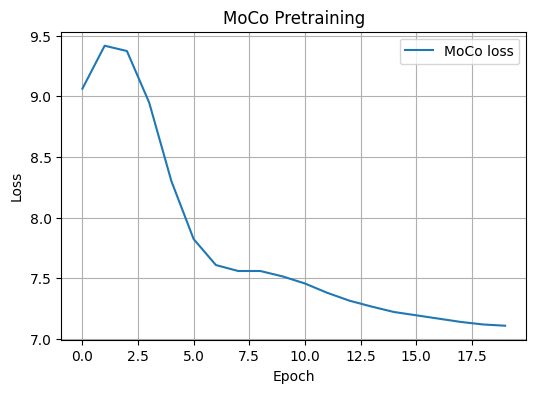

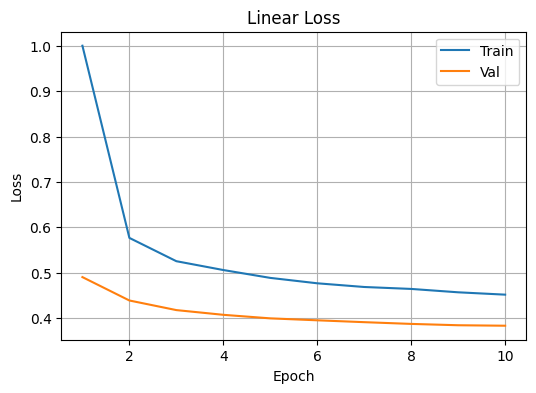

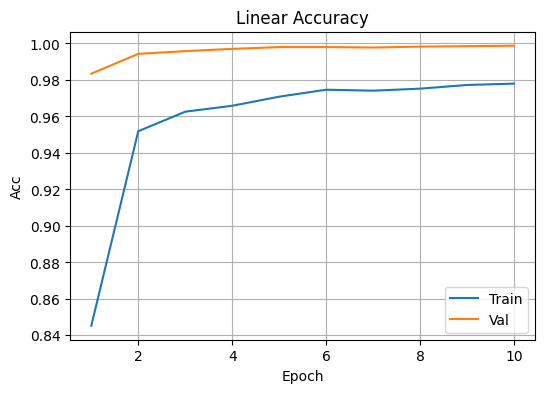

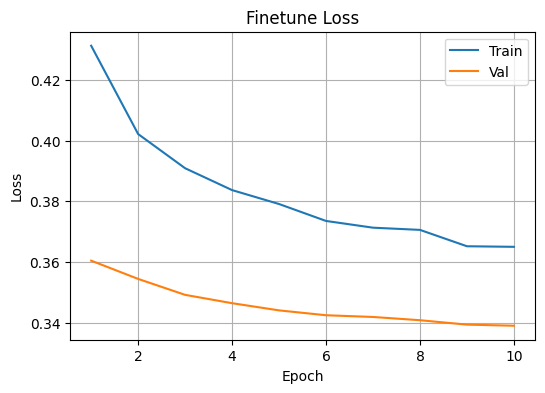

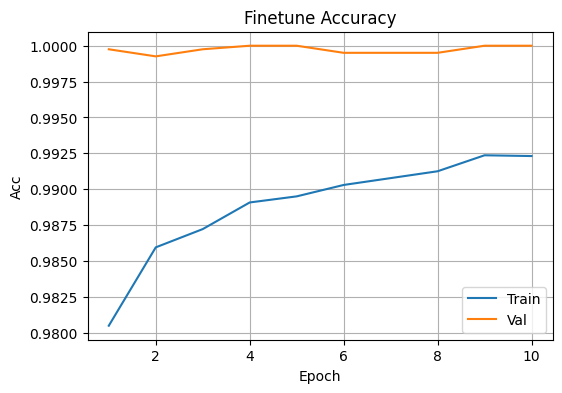

In [11]:
# MoCo loss
plt.figure(figsize=(6,4)); plt.plot(moco_losses, label="MoCo loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MoCo Pretraining"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(OUT_DIR, "moco_loss.png"), dpi=150); plt.show()

# Linear
e = range(1, len(lin_hist["train_loss"])+1)
plt.figure(figsize=(6,4))
plt.plot(e, lin_hist["train_loss"], label="Train")
plt.plot(e, lin_hist["val_loss"],   label="Val")
plt.title("Linear Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "linear_loss.png"), dpi=150); plt.show()

plt.figure(figsize=(6,4))
plt.plot(e, lin_hist["train_acc"], label="Train")
plt.plot(e, lin_hist["val_acc"],   label="Val")
plt.title("Linear Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "linear_acc.png"), dpi=150); plt.show()

# Finetune
e2 = range(1, len(ft_hist["train_loss"])+1)
plt.figure(figsize=(6,4))
plt.plot(e2, ft_hist["train_loss"], label="Train")
plt.plot(e2, ft_hist["val_loss"],   label="Val")
plt.title("Finetune Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "ft_loss.png"), dpi=150); plt.show()

plt.figure(figsize=(6,4))
plt.plot(e2, ft_hist["train_acc"], label="Train")
plt.plot(e2, ft_hist["val_acc"],   label="Val")
plt.title("Finetune Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "ft_acc.png"), dpi=150); plt.show()


Extract features:   0%|          | 0/32 [00:00<?, ?it/s]

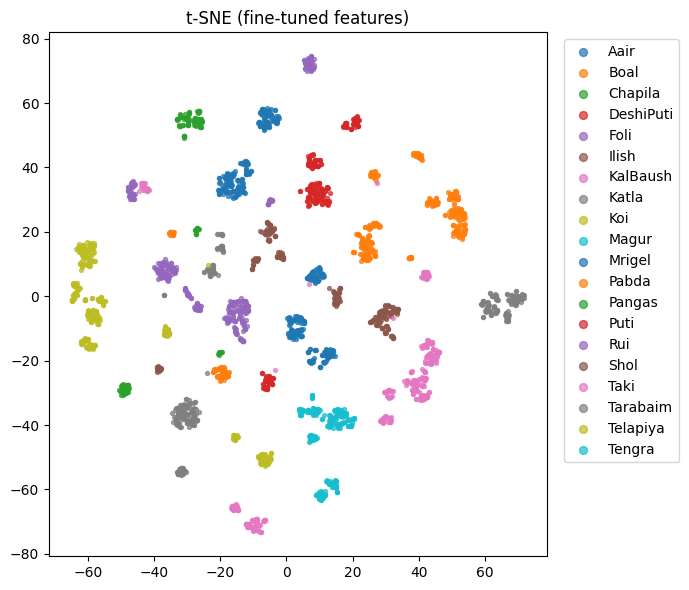

Saved t-SNE & plots to: /content/drive/MyDrive/moco_fish_outputs_fixed


In [12]:
# extract test features
backbone.eval()
all_feats, all_labels = [], []
with torch.no_grad():
    for imgs, t in tqdm(test_loader, desc="Extract features"):
        imgs = imgs.to(device); f = backbone(imgs)
        all_feats.append(f.cpu()); all_labels.append(t)
X = torch.cat(all_feats).numpy(); y = torch.cat(all_labels).numpy()

MAX_TSNE = 3000
if len(X) > MAX_TSNE:
    idx = np.random.choice(len(X), MAX_TSNE, replace=False)
    X, y = X[idx], y[idx]

perplexity = max(5, min(30, (len(X)-1)//3))
tsne = TSNE(n_components=2, learning_rate='auto', init='pca',
            perplexity=perplexity, random_state=SEED)
X2 = tsne.fit_transform(X)

plt.figure(figsize=(7,6))
classes = train_sup.classes
for ci, cn in enumerate(classes):
    m = (y==ci)
    if m.sum()==0: continue
    plt.scatter(X2[m,0], X2[m,1], s=8, alpha=0.7, label=cn)
plt.legend(markerscale=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.title("t-SNE (fine-tuned features)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "tsne_finetuned.png"), dpi=150); plt.show()
print("Saved t-SNE & plots to:", OUT_DIR)
